# Clustering Analysis
After conducting clustering using: K-Means (with unscaled/weighted data) and K-Means (scaled data) we determine which clustering makes most sense. After choosing, we rank the bikeability and walkability clusters on discomfort anchored based on the component prioritization results in [Arellana et. al 2020](https://www.sciencedirect.com/science/article/abs/pii/S0965856420306534) and [Boongaling et. al 2022](https://link.springer.com/article/10.1007/s10708-021-10441-2) respectively. For interpretability, we conduct linear regression with the determined rankings as the target variable in order to get the weights of each component.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import math
from shapely import wkt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
bike_kmeans = gpd.read_file('clustered_datasets/bike-kmeans-unscaled.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
walk_kmeans = gpd.read_file('clustered_datasets/walk-kmeans-unscaled.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

bike_kmeans_sc = gpd.read_file('clustered_datasets/bike-kmeans-scaled.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
walk_kmeans_sc = gpd.read_file('clustered_datasets/walk-kmeans-scaled.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

# Determining which clustering to use

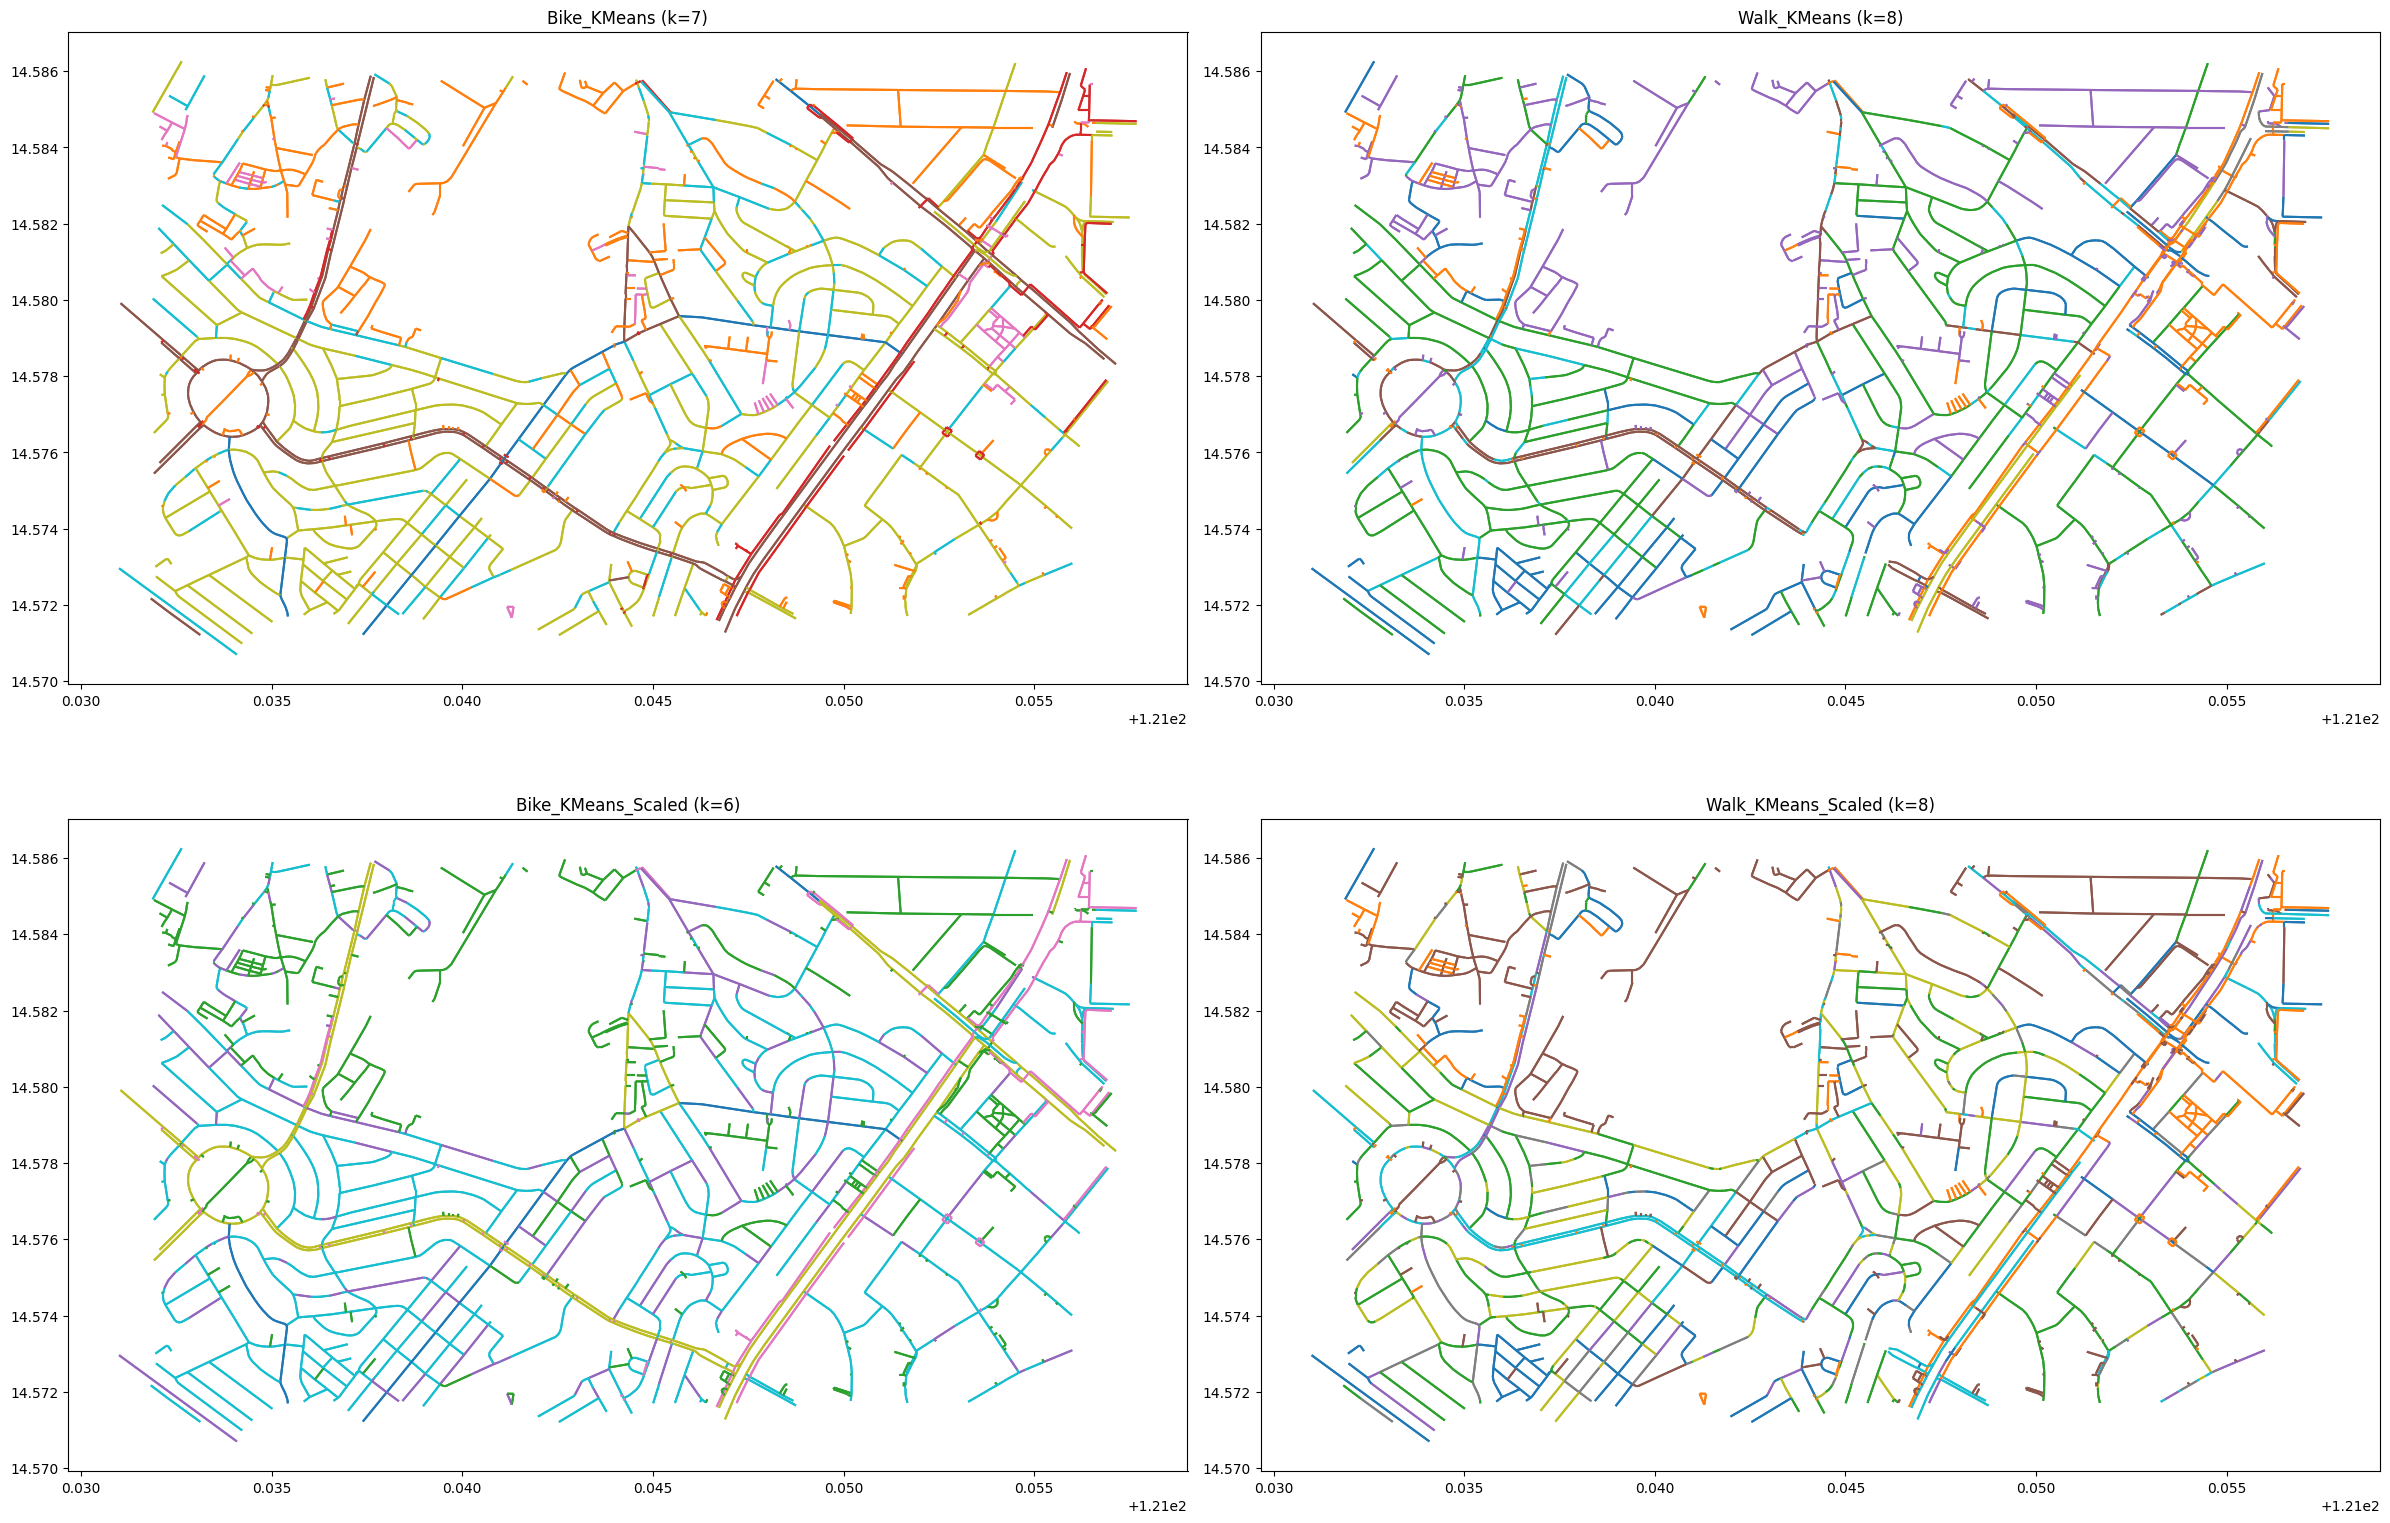

In [3]:
geodataframes = [bike_kmeans, walk_kmeans, bike_kmeans_sc, walk_kmeans_sc]
titles = ['Bike_KMeans', 'Walk_KMeans', 'Bike_KMeans_Scaled', 'Walk_KMeans_Scaled']

fig, axes = plt.subplots(2, 2, figsize=(24, 16))
axes = axes.flatten()

for i, gdf in enumerate(geodataframes):
    gdf.plot(column='cluster', ax=axes[i])
    axes[i].set_title(f'{titles[i]} (k={gdf.cluster.nunique()})')

plt.tight_layout()
plt.savefig('clustering_comparisons.jpg')
plt.show()

In [4]:
custom_cmap = ListedColormap(['grey', 'blue'])

In [5]:
def view_individual_clusters(gdf, subplot_size, figsize, title):
    fig, axes = plt.subplots(subplot_size[0], subplot_size[1], figsize=figsize)
    axes = axes.flatten()

    for i in range(gdf.cluster.nunique()):
        gdf['color'] = gdf['cluster'].apply(lambda x: 0 if x != str(i) else 1)
        gdf.plot(column='color', ax=axes[i], cmap=custom_cmap)
        axes[i].set_title(f'Cluster {i}') 

    if gdf.cluster.nunique() < subplot_size[0] * subplot_size[1]:
        fig.delaxes(axes[-1])
        
    plt.suptitle(f'{title}', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'{title}.jpg')
    plt.show()

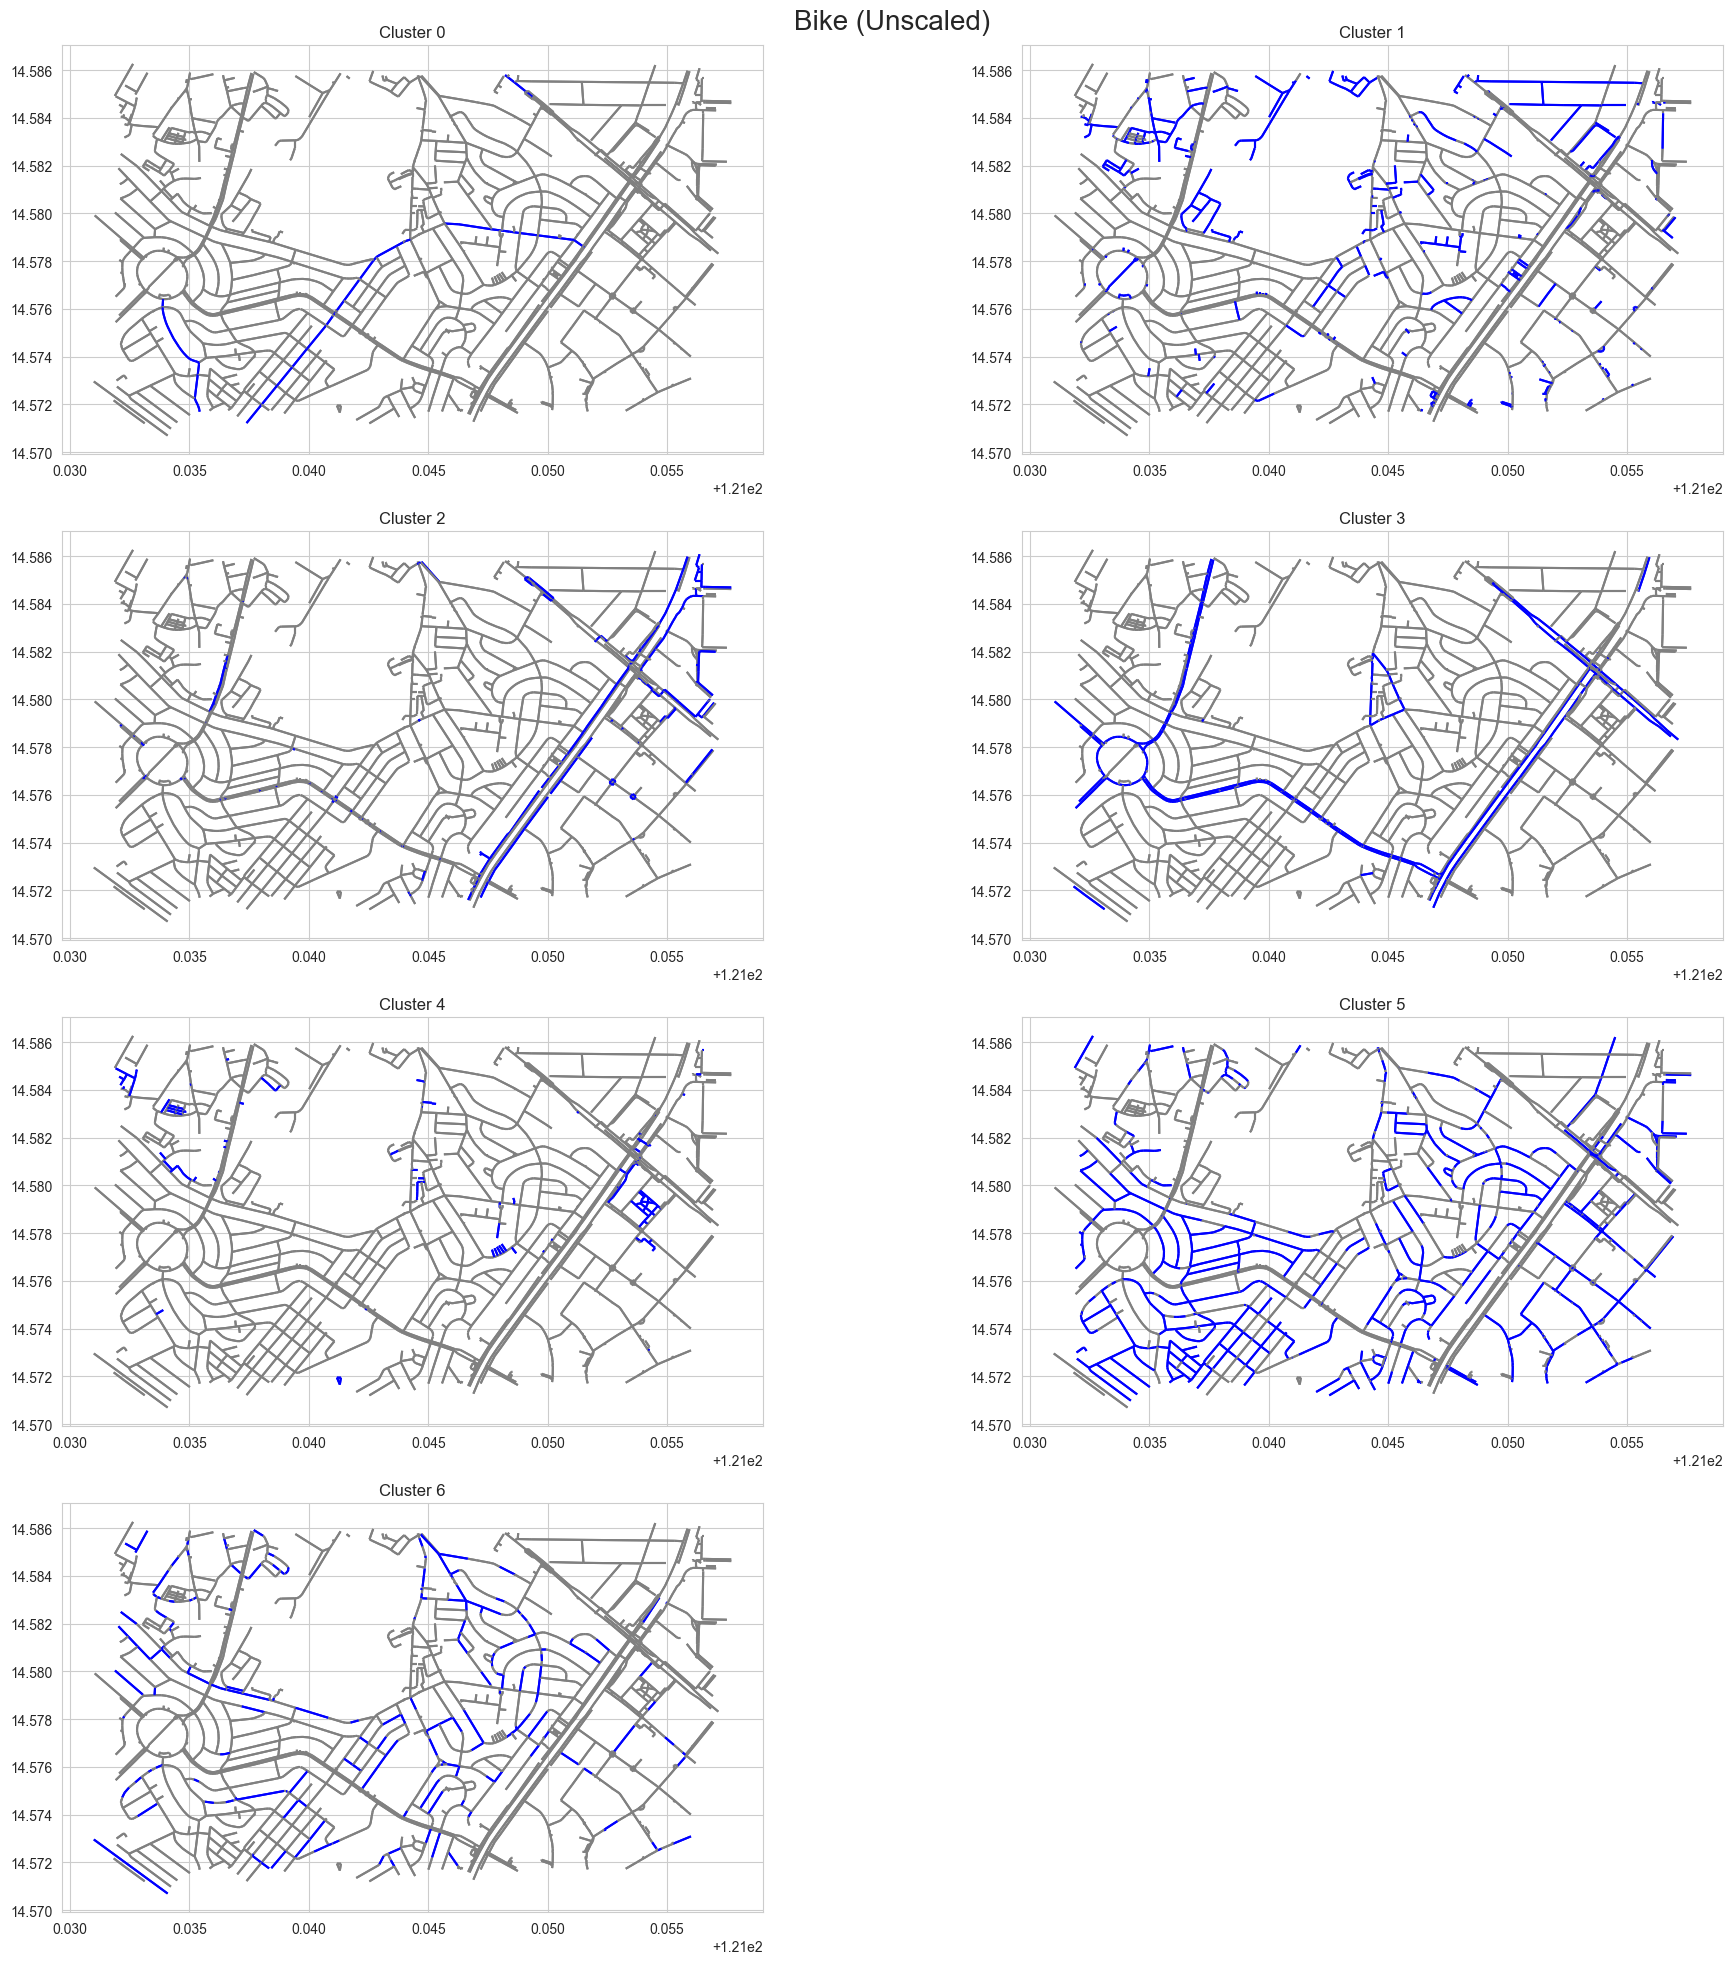

In [264]:
view_individual_clusters(bike_kmeans, (4,2), (20,20), 'Bike (Unscaled)')

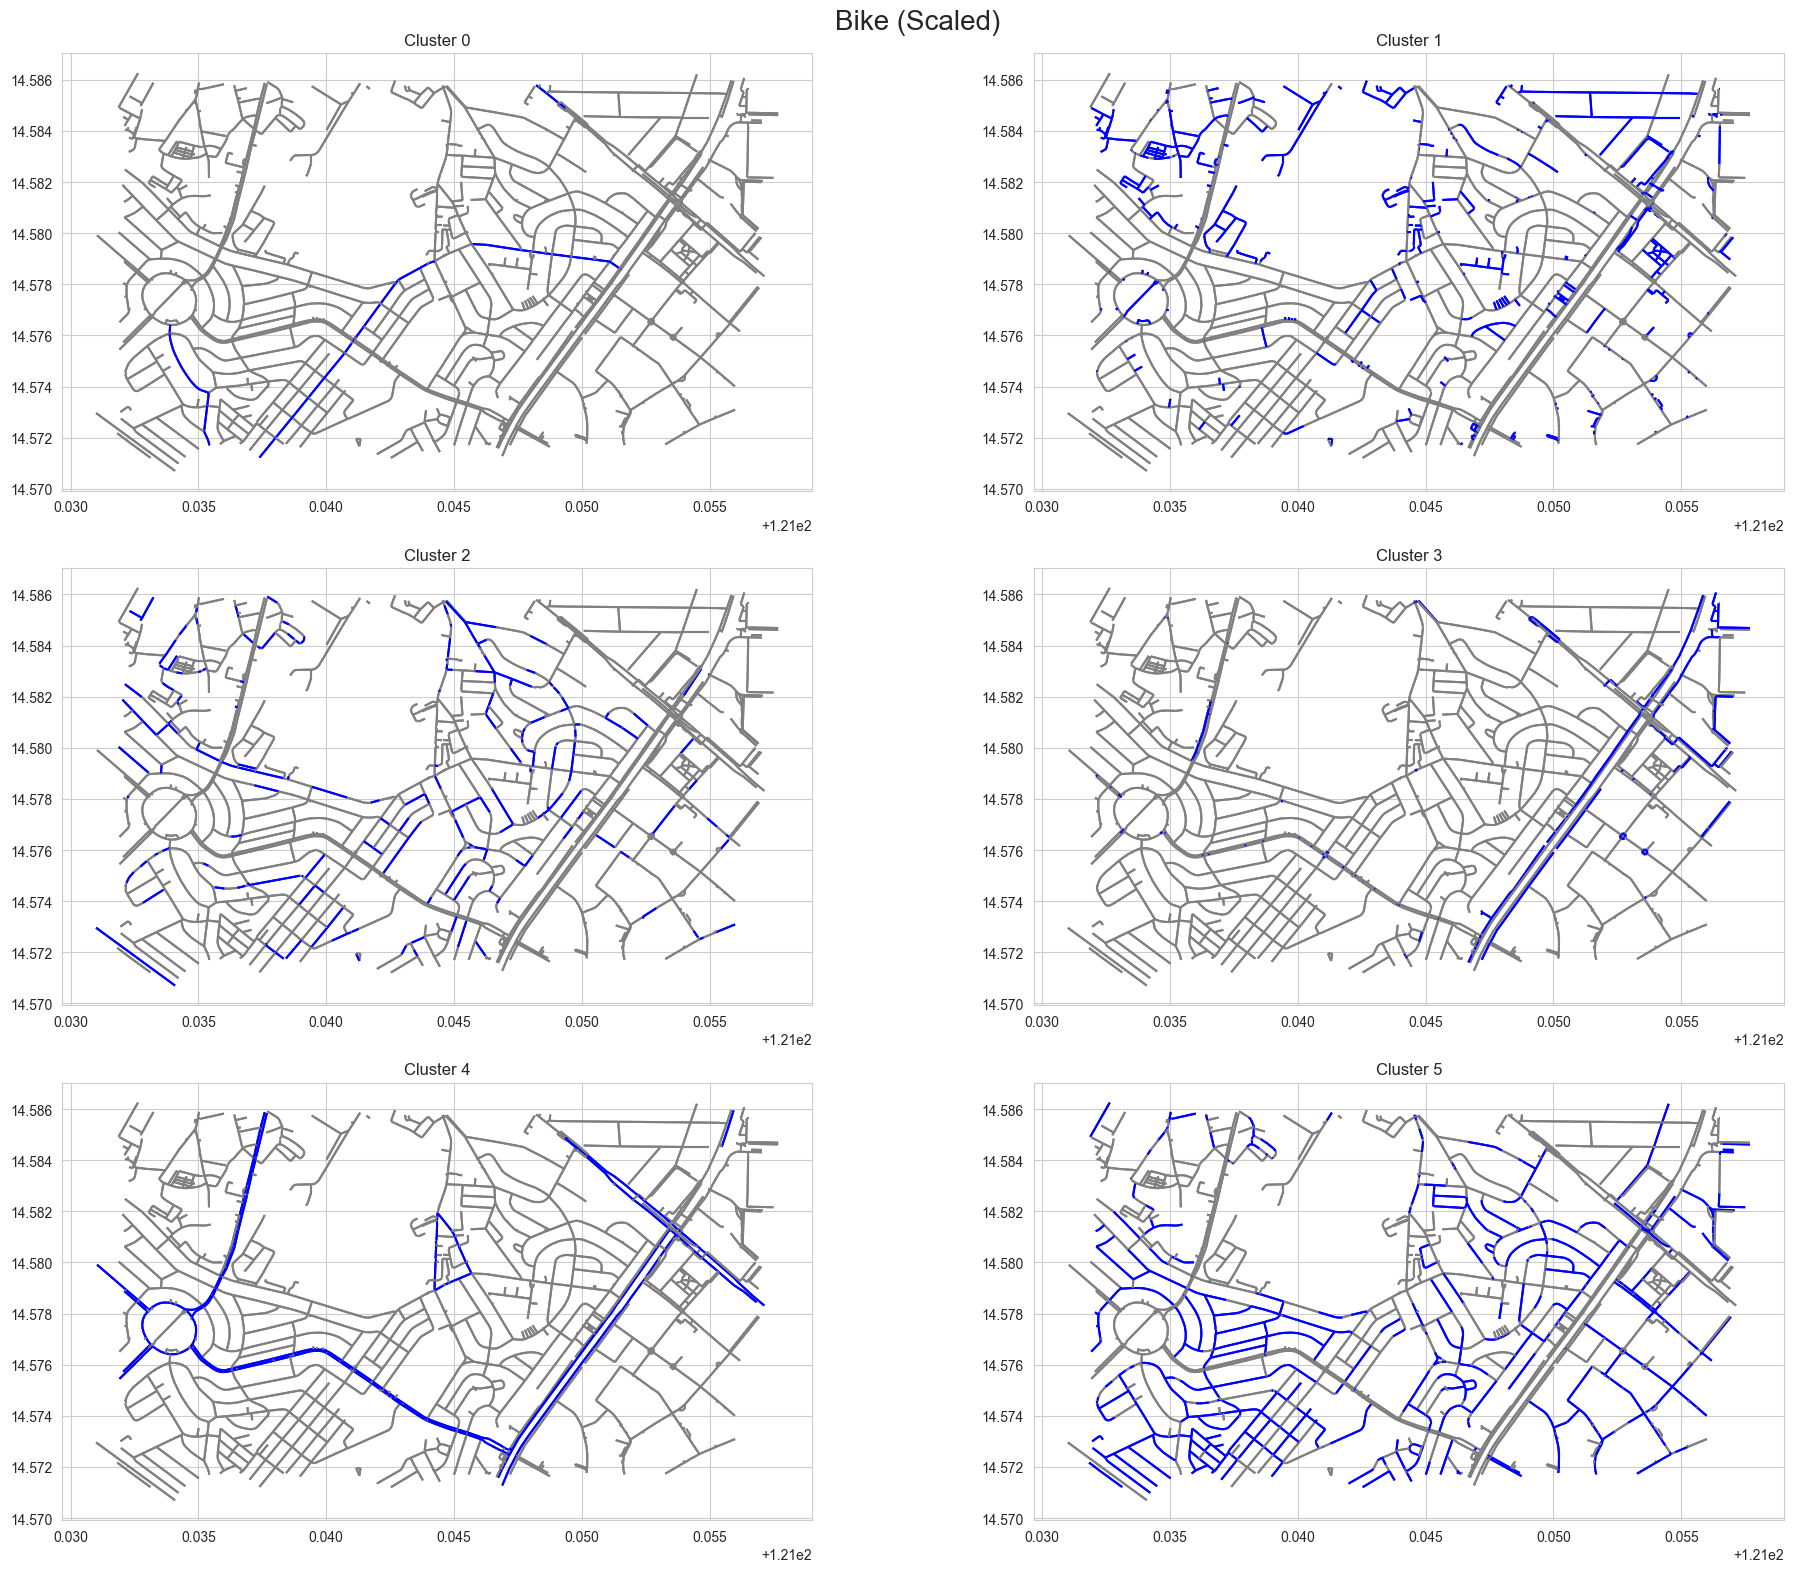

In [265]:
view_individual_clusters(bike_kmeans_sc, (3,2), (20,16), 'Bike (Scaled)')

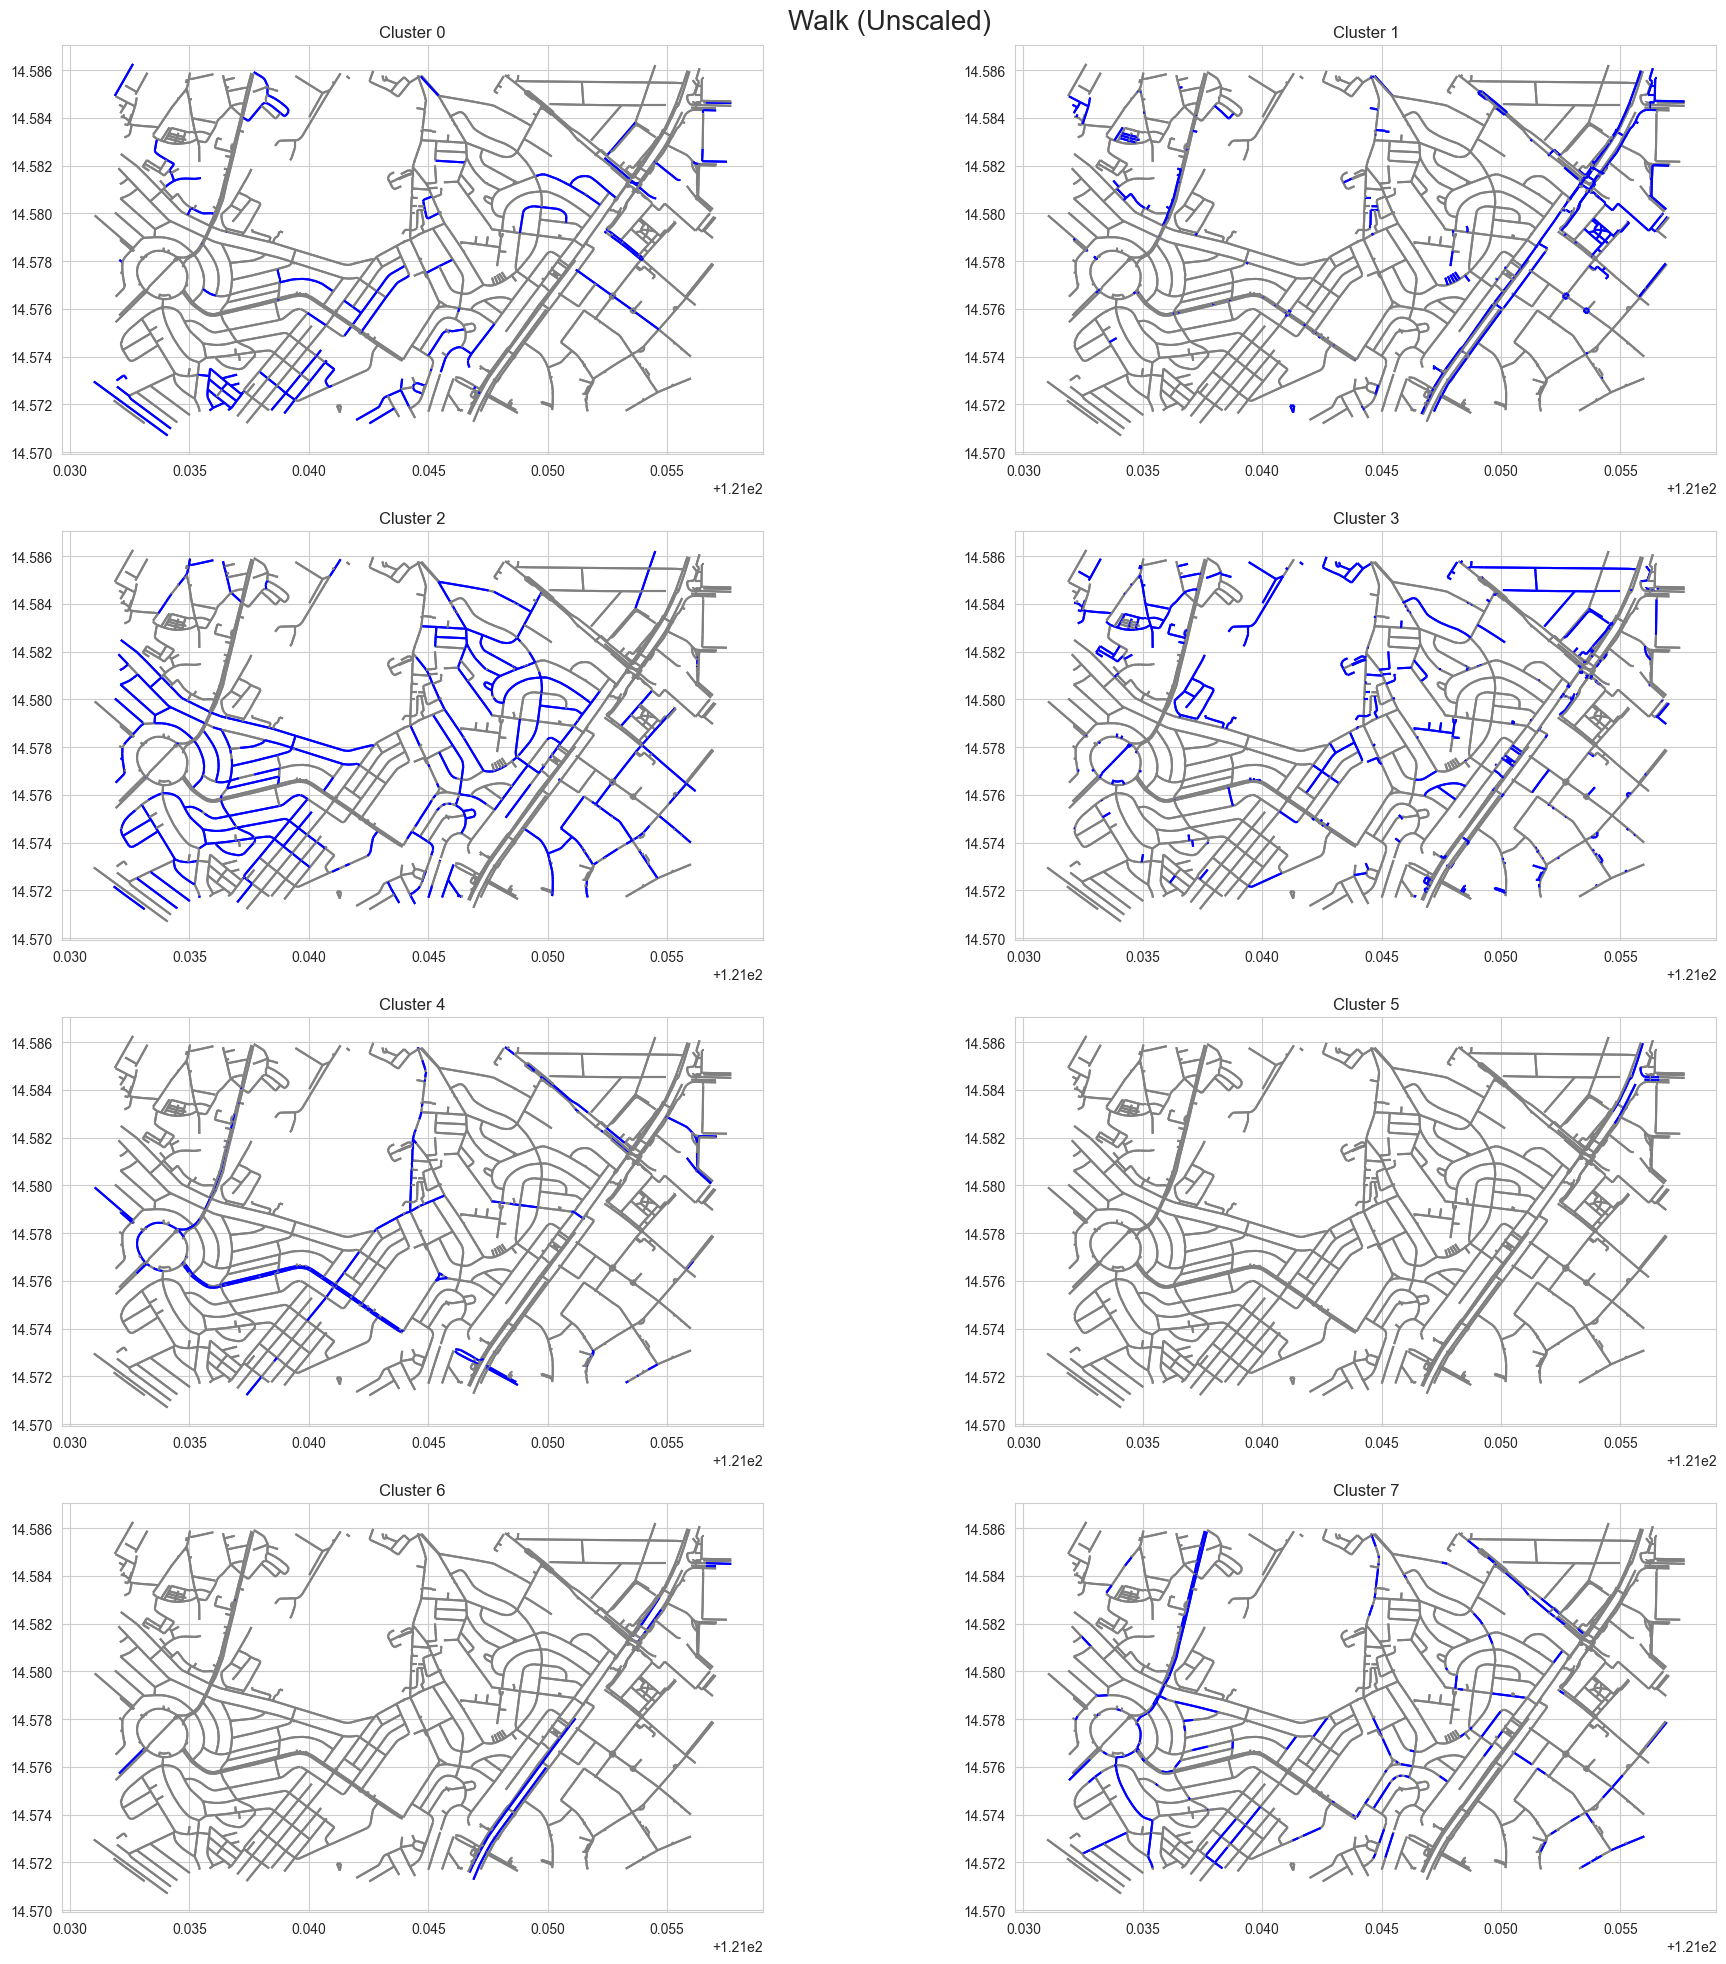

In [266]:
view_individual_clusters(walk_kmeans, (4,2), (20,20), 'Walk (Unscaled)')

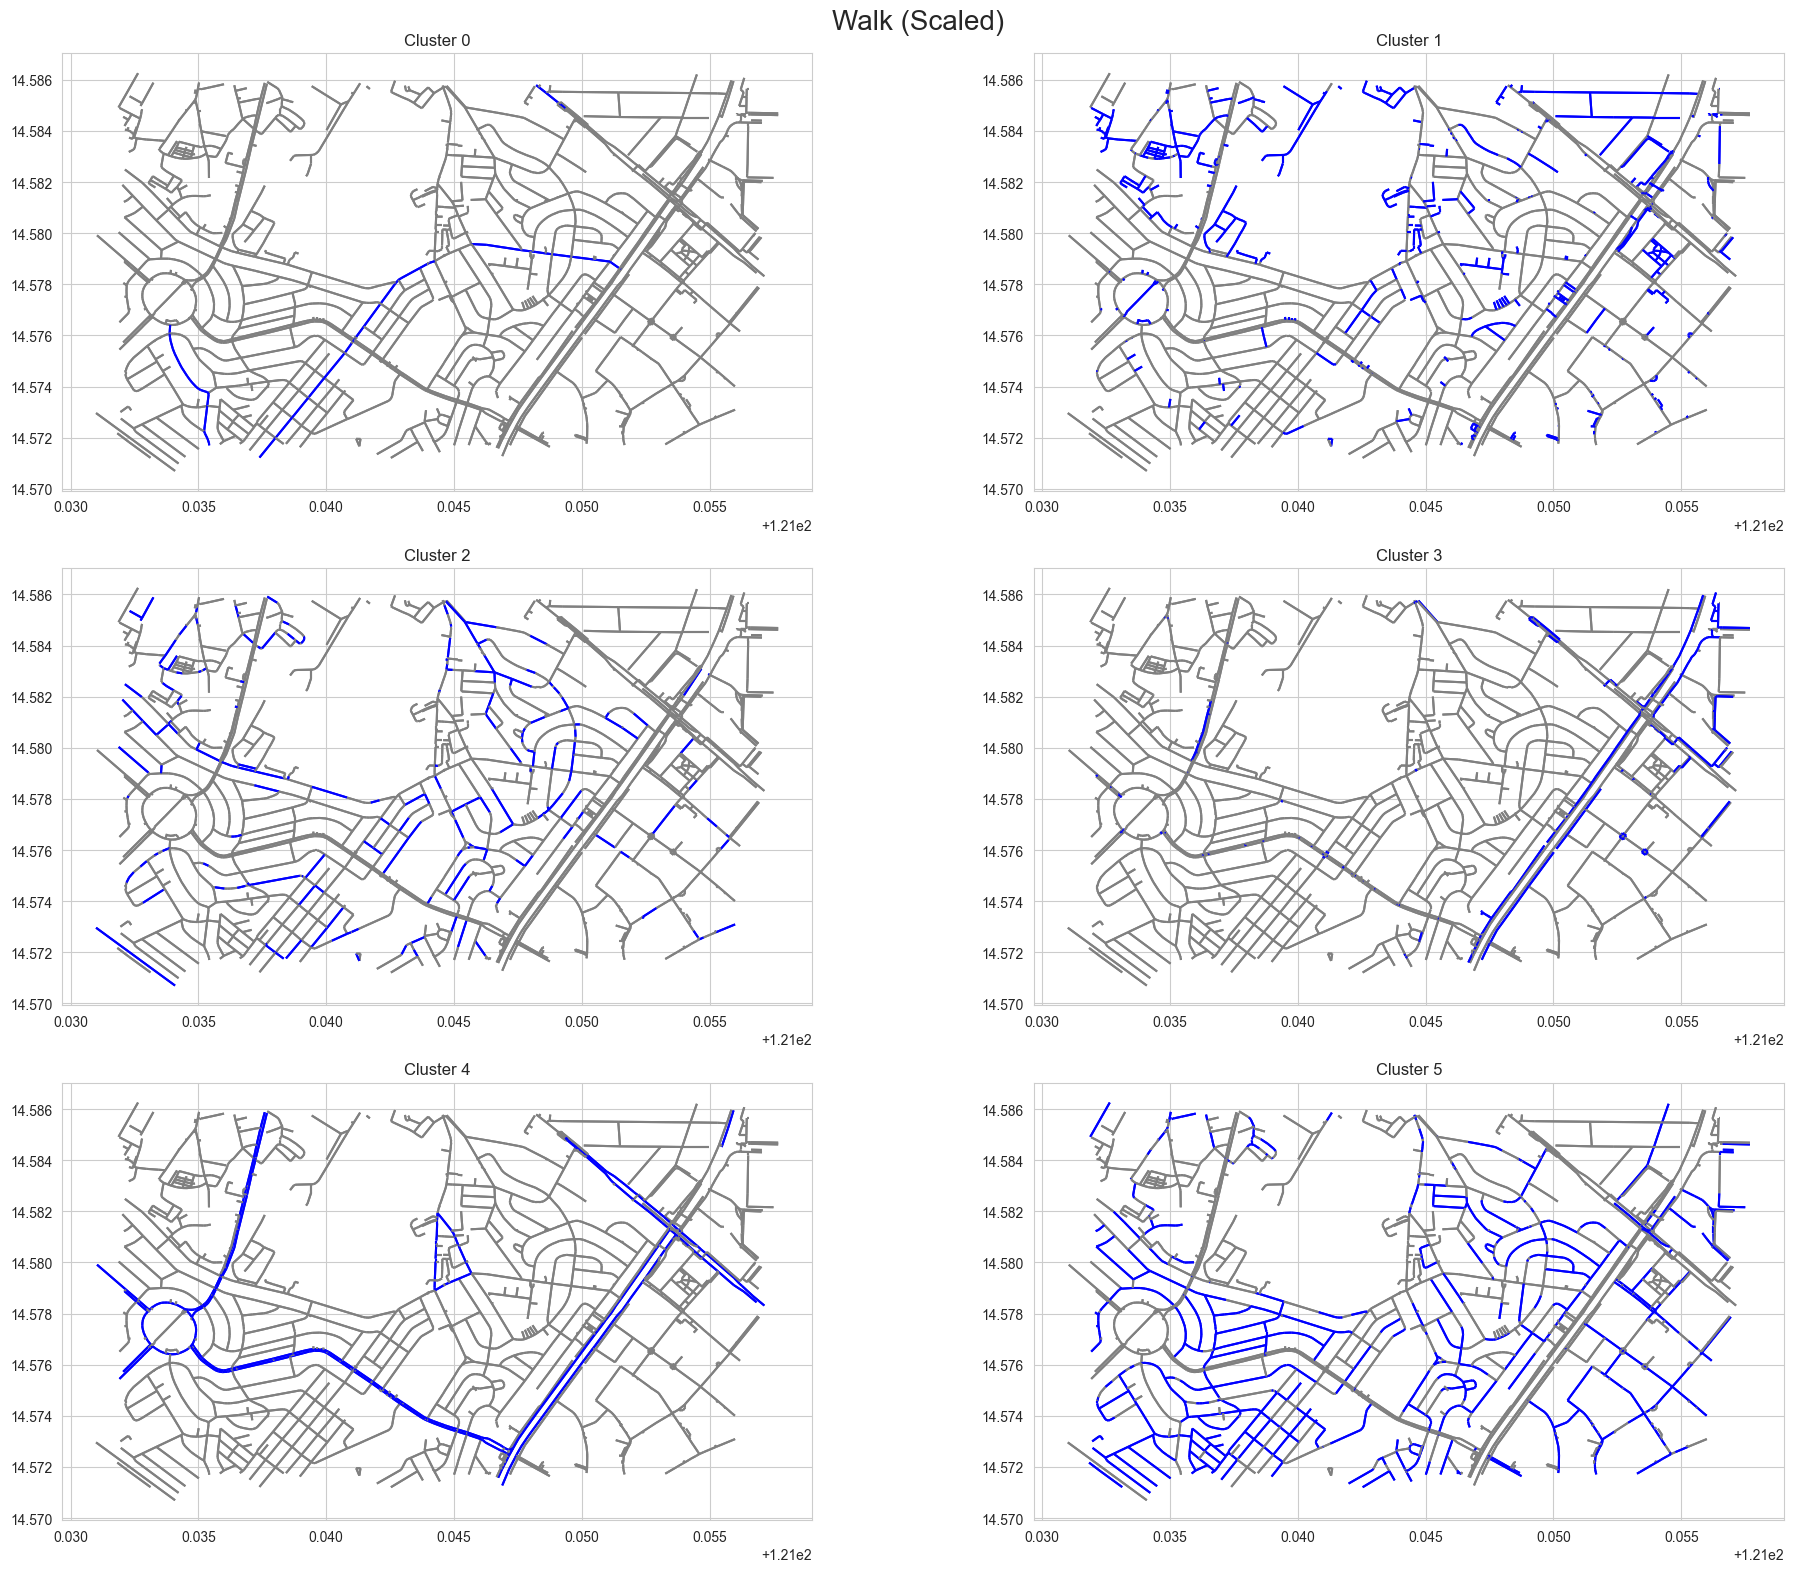

In [267]:
view_individual_clusters(bike_kmeans_sc, (3,2), (20,16), 'Walk (Scaled)')

For the bike clusters, notice how the clustering is mostly similar. But we choose the unscaled clustering as it also reflects the edges that are marked as `DISMOUNT`.

# Ranking the clusters

In [153]:
bike_without_mu = pd.read_csv('clustered_datasets/bike-kmeans-unscaled.csv')
walk_without_mu = pd.read_csv('clustered_datasets/walk-kmeans-unscaled.csv')

# unclustered, complete columns
bike_bounded = pd.read_csv('dfb_bound.csv')
walk_bounded = pd.read_csv('dfw_bound.csv')

In [188]:
walk_bounded.columns

Index(['u', 'v', 'key', 'score_weighted_by_main', 'score_weighted_by_sub',
       'SU_foot', 'SU_highway', 'SU_ALLEY', 'SU_width', 'SU_lit',
       'SU_maxspeed', 'SU_segregated', 'SU_sidewalk', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density',
       'MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       'MU_safety_of_crossings', 'geometry'],
      dtype='object')

We can use the main components removed earlier during clustering.

In [189]:
bike_MU = ['MU_DISMOUNT', 'MU_convenience',
       'MU_attractiveness', 'MU_traffic_safety', 'MU_security',
       'MU_accident_risk', 'MU_traffic_volume',
       'MU_safety_of_sidewalks_and_crossings']

walk_MU = ['MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       'MU_safety_of_crossings']

In [233]:
bike = pd.concat([bike_without_mu, bike_bounded[bike_MU]], axis=1)
walk = pd.concat([walk_without_mu, walk_bounded[walk_MU]], axis=1)

In [234]:
bike.columns

Index(['u', 'v', 'key', 'geometry', 'SU_DISMOUNT', 'SU_bicycle',
       'SU_CYCLEWAY_CLASS', 'SU_CYCLEWAY_LANE_TYPE', 'SU_foot', 'SU_highway',
       'SU_ALLEY', 'SU_lit', 'SU_maxspeed', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_cycling_lane_coverage', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'cluster', 'MU_DISMOUNT',
       'MU_convenience', 'MU_attractiveness', 'MU_traffic_safety',
       'MU_security', 'MU_accident_risk', 'MU_traffic_volume',
       'MU_safety_of_sidewalks_and_crossings'],
      dtype='object')

In [235]:
walk.columns

Index(['u', 'v', 'key', 'geometry', 'SU_foot', 'SU_highway', 'SU_ALLEY',
       'SU_lit', 'SU_maxspeed', 'SU_sidewalk', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density',
       'cluster', 'MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       'MU_safety_of_crossings'],
      dtype='object')

## Bikeability
We arrive at the following ranking (higher implies more discomfort):
1. Cluster 0
2. Cluster 3
3. Cluster 6
4. Cluster 5
5. Cluster 4
6. Cluster 1
7. Cluster 2

In [236]:
bike_mean = bike.groupby('cluster')[bike_MU].mean()
bike_mean

MU_DISMOUNT  MU_convenience  MU_attractiveness  MU_traffic_safety  \
cluster                                                                      
0                0.0       -3.083333          -0.222222          -3.472958   
1                0.0        0.089333          -0.001333          -0.079573   
2               10.0        0.000000          -0.027009           0.000000   
3                0.0       -2.870455          -0.106818          -1.065333   
4                0.0       -0.026596          -0.015957          -0.003200   
5                0.0        0.007739           0.000000          -0.036505   
6                0.0       -0.004878          -1.000000          -0.033773   

         MU_security  MU_accident_risk  MU_traffic_volume  \
cluster                                                     
0          -0.958333          0.000000           0.000000   
1           0.000000          0.000000          -0.268667   
2          -0.009934          0.000000          -4.000000   
3          -0.977273          0.040909          -0.061364   
4          -0.005319          0.000000          -2.159574   
5          -1.000000          0.002580          -0.337919   
6          -0.878049          0.004878          -0.370732   

         MU_safety_of_sidewalks_and_crossings  
cluster                                        
0                                    0.000000  
1                                    0.000000  
2                                    0.016556  
3                                    0.000000  
4                                    0.000000  
5                                    0.000000  
6                                    0.000000

Following the results from Arellana  et. al, we prioritize the following main components (in order):
1. MU_security
2. MU_safety_of_sidewalks_and_crossings
3. MU_accident_risk
4. MU_traffic_safety
5. MU_convenience
6. MU_DISMOUNT
7. MU_traffic_volume
8. MU_attractiveness

In [237]:
bike_order = ['MU_security', 'MU_safety_of_sidewalks_and_crossings', 'MU_accident_risk', 'MU_traffic_safety', 'MU_convenience', 'MU_DISMOUNT', 'MU_traffic_volume', 'MU_attractiveness']
bike_mean.sort_values(bike_order)

MU_DISMOUNT  MU_convenience  MU_attractiveness  MU_traffic_safety  \
cluster                                                                      
5                0.0        0.007739           0.000000          -0.036505   
3                0.0       -2.870455          -0.106818          -1.065333   
0                0.0       -3.083333          -0.222222          -3.472958   
6                0.0       -0.004878          -1.000000          -0.033773   
2               10.0        0.000000          -0.027009           0.000000   
4                0.0       -0.026596          -0.015957          -0.003200   
1                0.0        0.089333          -0.001333          -0.079573   

         MU_security  MU_accident_risk  MU_traffic_volume  \
cluster                                                     
5          -1.000000          0.002580          -0.337919   
3          -0.977273          0.040909          -0.061364   
0          -0.958333          0.000000           0.000000   
6          -0.878049          0.004878          -0.370732   
2          -0.009934          0.000000          -4.000000   
4          -0.005319          0.000000          -2.159574   
1           0.000000          0.000000          -0.268667   

         MU_safety_of_sidewalks_and_crossings  
cluster                                        
5                                    0.000000  
3                                    0.000000  
0                                    0.000000  
6                                    0.000000  
2                                    0.016556  
4                                    0.000000  
1                                    0.000000

In [238]:
# Add weights
def rank_clusters(dataframe, features_in_order):
    # Normalize the weights to ensure they sum up to 1 for simplicity
    weights = np.linspace(1, 0.1, num=len(features_in_order)) 
    weights = weights / weights.sum()

    weighted_values = dataframe[features_in_order].mul(weights, axis=1)
    dataframe['ranking_score'] = weighted_values.sum(axis=1)

    ranked_clusters = dataframe.sort_values('ranking_score')
    return ranked_clusters[['ranking_score'] + features_in_order]

In [239]:
def generate_violin_plots(dataframe, columns, hue_column='cluster'):
    num_columns = len(columns)
    num_rows = math.ceil(num_columns / 3)
    num_cols = min(num_columns, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.violinplot(data=dataframe, x=hue_column, y=col, ax=axes[i])
        axes[i].set_title(f"{col}")
        
    # Hide any extra subplots if number of columns is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [240]:
ranked = rank_clusters(bike_mean, bike_order)
ranked

ranking_score  MU_security  MU_safety_of_sidewalks_and_crossings  \
cluster                                                                     
0            -1.048083    -0.958333                              0.000000   
3            -0.686416    -0.977273                              0.000000   
5            -0.248634    -1.000000                              0.000000   
6            -0.245973    -0.878049                              0.000000   
4            -0.117140    -0.005319                              0.000000   
1            -0.015235     0.000000                              0.000000   
2             0.604304    -0.009934                              0.016556   

         MU_accident_risk  MU_traffic_safety  MU_convenience  MU_DISMOUNT  \
cluster                                                                     
0                0.000000          -3.472958       -3.083333          0.0   
3                0.040909          -1.065333       -2.870455          0.0   
5                0.002580          -0.036505        0.007739          0.0   
6                0.004878          -0.033773       -0.004878          0.0   
4                0.000000          -0.003200       -0.026596          0.0   
1                0.000000          -0.079573        0.089333          0.0   
2                0.000000           0.000000        0.000000         10.0   

         MU_traffic_volume  MU_attractiveness  
cluster                                        
0                 0.000000          -0.222222  
3                -0.061364          -0.106818  
5                -0.337919           0.000000  
6                -0.370732          -1.000000  
4                -2.159574          -0.015957  
1                -0.268667          -0.001333  
2                -4.000000          -0.027009

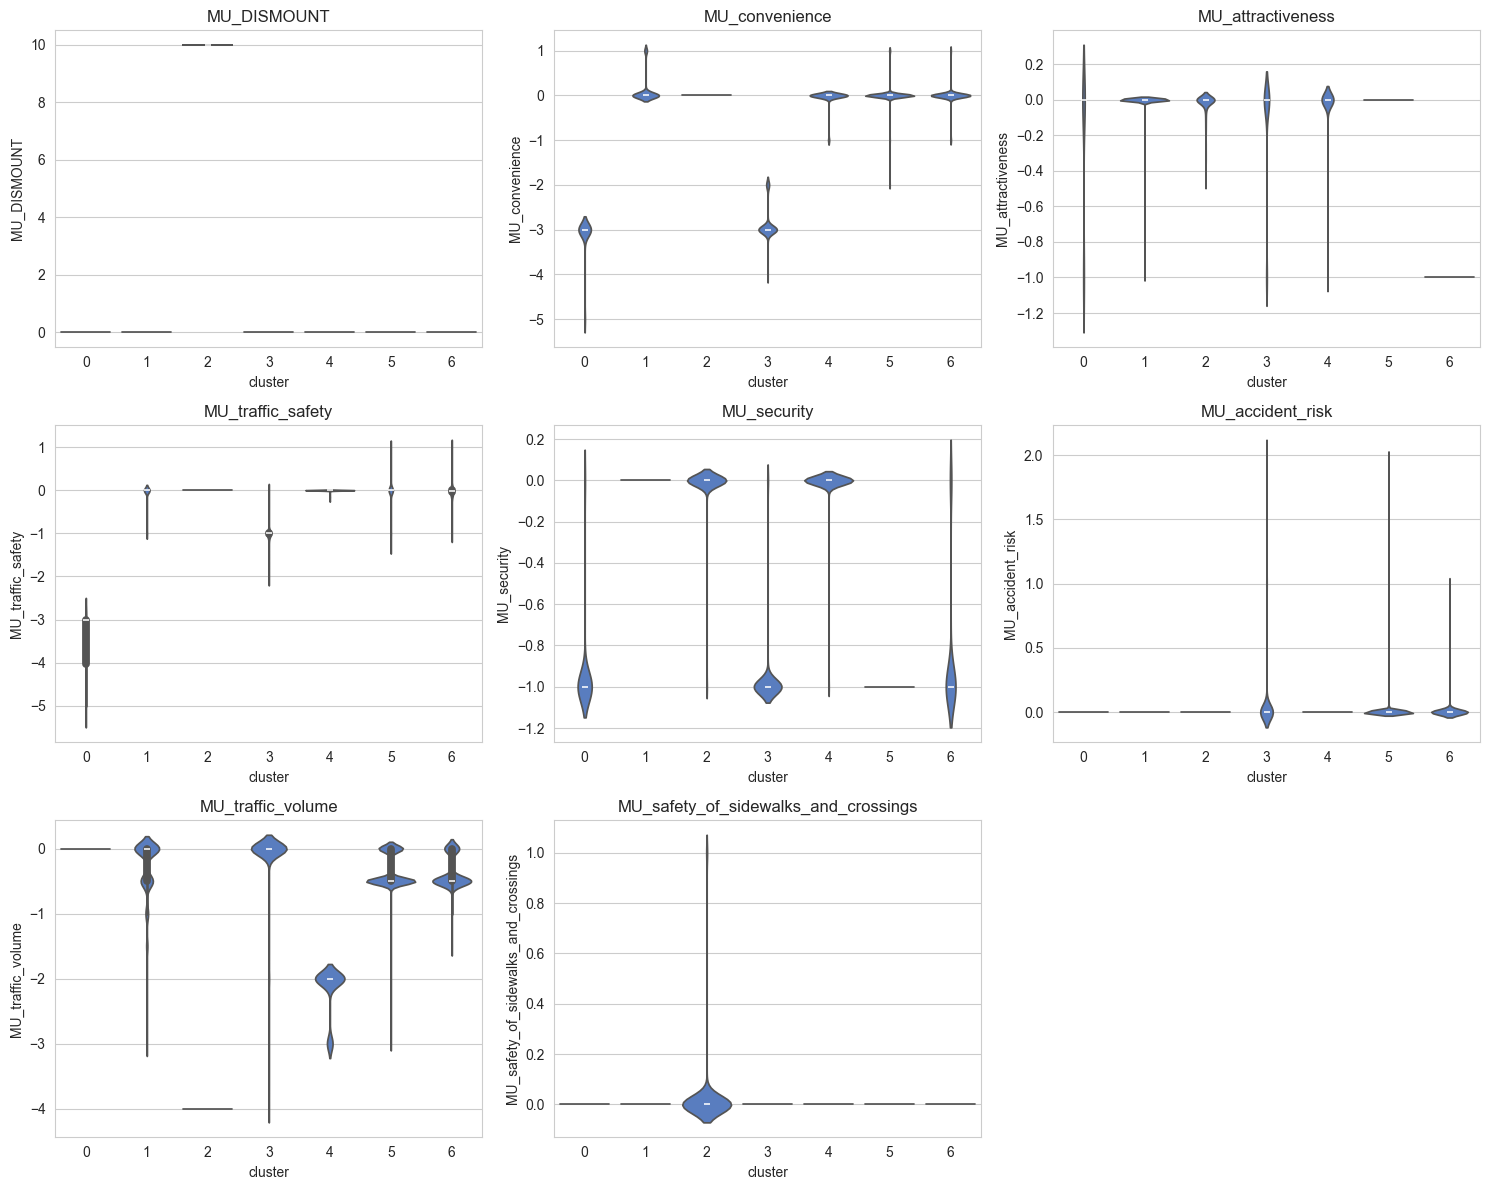

In [241]:
generate_violin_plots(bike, bike_MU)

- We can put cluster 2 at the bottom of the list. It has the worst values in multiple feature such as `MU_SECURITY` and `MU_traffic_volume`, and also has the `SU_DISMOUNT` value.
- Cluster 1 can be the next one. Looking at the visualized map as well, edges from this cluster are often small edges in residential areas.
- The same can be said for cluster 4, but it ranks higher than cluster 1 as it has slightly better values in other features.
- We put cluster 5 next due to its `MU_traffic_safety` and `MU_traffic_volume`. Based on the map, these are also mainly residential areas.
- Then we have cluster 6.
- We then put cluster 3 next due to its `MU_accident_risk`, despite having similar values with the remaining clusters.
- And finally cluster 0, due to its high `MU_traffic_safety` and `MU_convenience`.

## Walkability

We arrive at the following ranking (higher implies more discomfort):
1. Cluster 0
2. Cluster 1
3. Cluster 6
4. Cluster 7
5. Cluster 5
6. Cluster 3
7. Cluster 4
8. Cluster 2


In [242]:
walk.columns

Index(['u', 'v', 'key', 'geometry', 'SU_foot', 'SU_highway', 'SU_ALLEY',
       'SU_lit', 'SU_maxspeed', 'SU_sidewalk', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density',
       'cluster', 'MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       'MU_safety_of_crossings'],
      dtype='object')

In [243]:
walk_mean = walk.groupby('cluster')[walk_MU].mean()

Following the results from Arellana  et. al, we prioritize the following main components (in order):
1. MU_safety_of_sidewalks
2. MU_safety_of_crossings
3. MU_accident_risk
4. MU_traffic_speed
6. MU_traffic_volume
7. MU_convenience
8. MU_attractiveness

In [244]:
walk_order = ['MU_safety_of_sidewalks', 'MU_safety_of_crossings', 'MU_accident_risk', 'MU_traffic_speed', 'MU_traffic_volume', 'MU_convenience', 'MU_attractiveness']
walk_mean.sort_values(walk_order)

MU_convenience  MU_traffic_volume  MU_traffic_speed  \
cluster                                                        
5              1.870185           0.034483          0.706897   
0             -0.057570          -0.403005         -0.168033   
6             -2.049874           0.000000          0.866667   
1             -0.058865          -3.956124         -0.021938   
3             -0.102780          -0.184242         -0.078791   
4             -0.045522           0.000000          0.803867   
7             -0.365925          -0.117225          0.330144   
2             -0.061889          -0.366879         -0.079618   

         MU_attractiveness  MU_accident_risk  MU_safety_of_sidewalks  \
cluster                                                                
5                -0.034119          0.103448               -1.227092   
0                -0.038124          0.000000               -1.068084   
6                -0.024247          0.288889               -0.995200   
1                -0.023808          0.000000               -0.053384   
3                -0.018358          0.000000               -0.025375   
4                -0.037130          0.000000                0.284962   
7                -0.123320          0.000000                0.405836   
2                -0.060235          0.000000                0.876655   

         MU_safety_of_crossings  
cluster                          
5                     -0.413793  
0                     -0.054645  
6                     -0.133333  
1                     -0.073126  
3                     -0.031991  
4                      0.000000  
7                     -1.000000  
2                     -0.016561

In [245]:
ranked = rank_clusters(walk_mean, walk_order)
ranked

ranking_score  MU_safety_of_sidewalks  MU_safety_of_crossings  \
cluster                                                                  
1            -0.448612               -0.053384               -0.073126   
0            -0.360093               -1.068084               -0.054645   
6            -0.245334               -0.995200               -0.133333   
5            -0.166151               -1.227092               -0.413793   
7            -0.107348                0.405836               -1.000000   
3            -0.051202               -0.025375               -0.031991   
2             0.168972                0.876655               -0.016561   
4             0.184934                0.284962                0.000000   

         MU_accident_risk  MU_traffic_speed  MU_traffic_volume  \
cluster                                                          
1                0.000000         -0.021938          -3.956124   
0                0.000000         -0.168033          -0.403005   
6                0.288889          0.866667           0.000000   
5                0.103448          0.706897           0.034483   
7                0.000000          0.330144          -0.117225   
3                0.000000         -0.078791          -0.184242   
2                0.000000         -0.079618          -0.366879   
4                0.000000          0.803867           0.000000   

         MU_convenience  MU_attractiveness  
cluster                                     
1             -0.058865          -0.023808  
0             -0.057570          -0.038124  
6             -2.049874          -0.024247  
5              1.870185          -0.034119  
7             -0.365925          -0.123320  
3             -0.102780          -0.018358  
2             -0.061889          -0.060235  
4             -0.045522          -0.037130

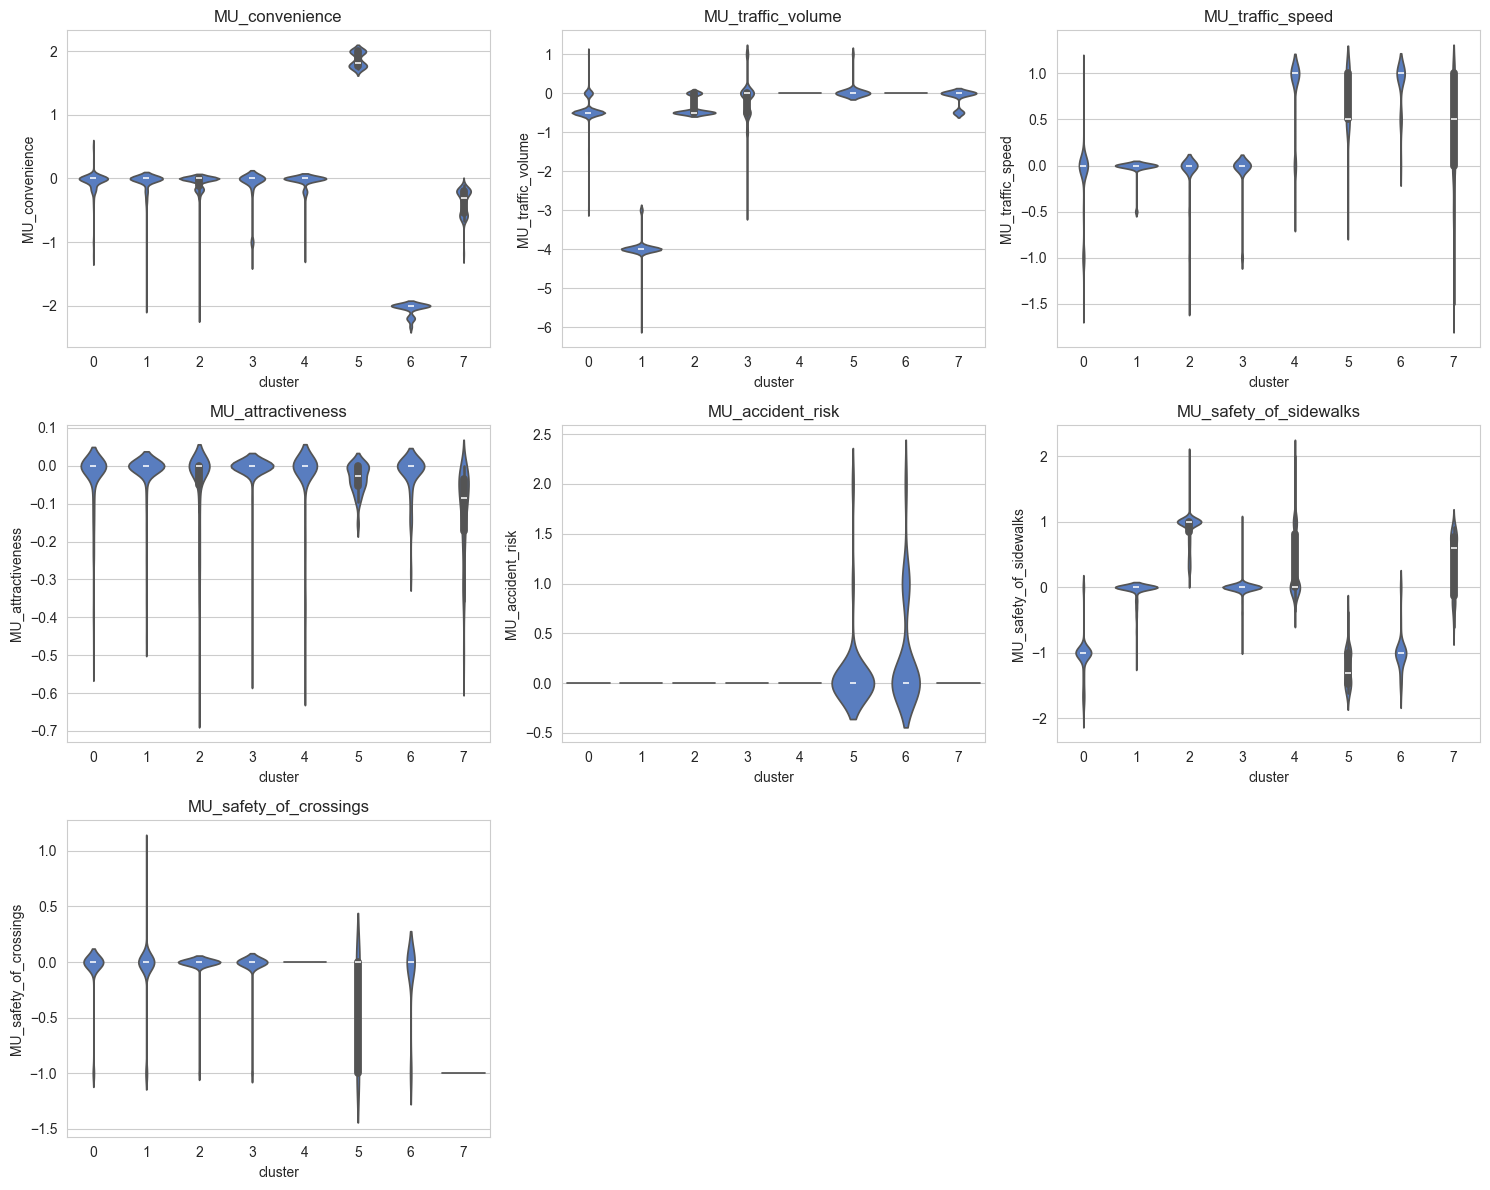

In [246]:
generate_violin_plots(walk, walk_MU)

- We can put cluster 2 last, has the worse `MU_safety_of_sidewalks`.
- Then cluster 4, as it has bad `MU_safety_of_sidewalks` and `MU_safety_of_crossings` andv looks like main roads.
- Cluster 3 has the worst `MU_security`.
- Cluster 5
- Cluster 7 has high `accident_risk`.
- Cluster 6
- Cluster 1, due to its good `MU_traffic_volume`.
- Cluster 0, due to its good `MU_safety_of_sidewalks`.

# Visualizing the rankings

In [247]:
bikeability_ranking = {
    0:1,
    3:2,
    5:3,
    6:4,
    4:5,
    2:6,
    1:7,
}

walkability_ranking = {
    0:1,
    1:2,
    6:3,
    7:4,
    5:5,
    3:6,
    4:7,
    2:8,
}

In [248]:
bike['rank'] = bike['cluster'].replace(bikeability_ranking)
walk['rank'] = walk['cluster'].replace(walkability_ranking)

bike.loc[:,'geometry'] = bike['geometry'].apply(wkt.loads)
bike_geo = gpd.GeoDataFrame(bike, geometry='geometry')

walk.loc[:,'geometry'] = walk['geometry'].apply(wkt.loads)
walk_geo = gpd.GeoDataFrame(walk, geometry='geometry')

In [249]:
def visualize_rank(df, title, column='rank'):
    sns.set_style("whitegrid")
    sns.set_palette("muted")
    
    df.plot(
        column='rank', 
        legend=True, 
        cmap='RdYlGn_r')
    
    plt.title(title)
    plt.savefig(f'{title}.jpg')
    plt.show()

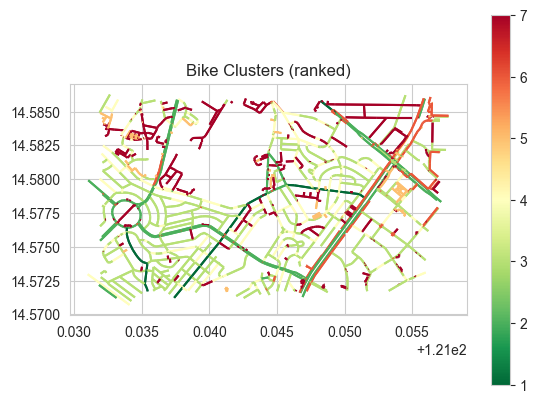

In [262]:
visualize_rank(bike_geo, 'Bike Clusters (ranked)')

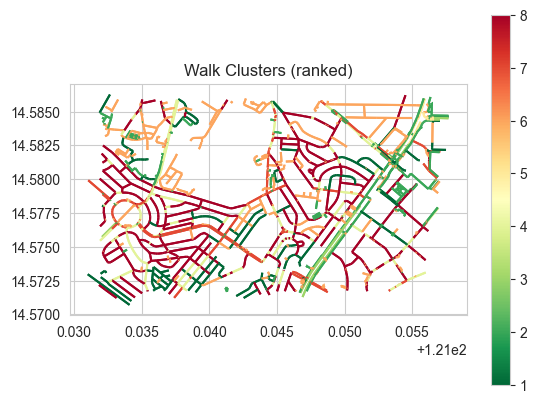

In [263]:
visualize_rank(walk_geo, 'Walk Clusters (ranked)')

## Applying linear regression

In [252]:
# Step 2: Pipeline
def perform_linear_regression(X, y):
    pipeline = Pipeline(steps=[
        ('linear_regression', LinearRegression())
    ])

    pipeline.fit(X, y)

    weights = pipeline.named_steps['linear_regression'].coef_
    intercept = pipeline.named_steps['linear_regression'].intercept_

    encoded_feature_names = X.columns
    
    # Create summary
    coef_summary = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Coefficient': weights
    })
    coef_summary.sort_values('Coefficient', ascending=False, inplace=True)

    return coef_summary, intercept, pipeline

In [253]:
bike_SU =  ['SU_DISMOUNT', 'SU_bicycle', 'SU_CYCLEWAY_CLASS', 'SU_CYCLEWAY_LANE_TYPE', 'SU_foot', 'SU_highway',
       'SU_ALLEY', 'SU_lit', 'SU_maxspeed', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_cycling_lane_coverage', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition']

walk_SU = ['SU_foot', 'SU_highway', 'SU_ALLEY',
       'SU_lit', 'SU_maxspeed', 'SU_sidewalk', 'SU_PARKING_SUBTAGS',
       'SU_TAG_crossing', 'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density']

### Bikeability (subcomponents)

In [254]:
bike_su_coef, bike_su_int, bike_su_pipeline = perform_linear_regression(bike[bike_SU], bike['rank'])

In [255]:
bike_su_coef

Feature   Coefficient
2                      SU_CYCLEWAY_CLASS  4.104993e+11
7                                 SU_lit  3.568467e+00
5                             SU_highway  8.027462e-01
9                     SU_PARKING_SUBTAGS  6.984041e-01
0                            SU_DISMOUNT  5.679694e-01
1                             SU_bicycle  3.374001e-01
12                      SU_motor_vehicle  2.237571e-01
13  SU_FROM_IMAGES_cycling_lane_coverage  1.333930e-01
8                            SU_maxspeed  1.031030e-01
15         SU_FROM_IMAGES_road_condition  1.025474e-01
11            SU_EDSA_accident_component  4.702946e-02
10                       SU_TAG_crossing -2.568568e-02
6                               SU_ALLEY -3.580916e-02
4                                SU_foot -5.172116e-02
14         SU_FROM_IMAGES_greenery_ratio -3.700764e-01
3                  SU_CYCLEWAY_LANE_TYPE -4.104993e+11

### Bikeability (main components)

In [256]:
bike_mu_coef, bike_mu_int, bike_mu_pipeline = perform_linear_regression(bike[bike_MU], bike['rank'])

In [257]:
bike_mu_coef

Feature  Coefficient
4                           MU_security     3.573670
6                     MU_traffic_volume     0.734551
1                        MU_convenience     0.435656
3                     MU_traffic_safety     0.222055
0                           MU_DISMOUNT     0.202651
7  MU_safety_of_sidewalks_and_crossings    -0.025502
5                      MU_accident_risk    -0.259225
2                     MU_attractiveness    -0.385812

### Walkability (subcomponents)

In [258]:
walk_su_coef, walk_su_int, walk_su_pipeline = perform_linear_regression(walk[walk_SU], walk['rank'])

In [259]:
walk_su_coef

Feature  Coefficient
3                               SU_lit     3.678636
14        SU_FROM_IMAGES_has_crosswalk     1.953867
15  SU_FROM_IMAGES_obstruction_density     1.617058
6                   SU_PARKING_SUBTAGS     1.242285
8           SU_EDSA_accident_component     1.197258
1                           SU_highway     0.955966
4                          SU_maxspeed     0.669531
0                              SU_foot     0.552127
2                             SU_ALLEY     0.443628
11       SU_FROM_IMAGES_greenery_ratio    -0.177764
12       SU_FROM_IMAGES_road_condition    -0.241016
7                      SU_TAG_crossing    -0.247398
10       SU_FROM_IMAGES_sidewalk_ratio    -0.306269
9                     SU_motor_vehicle    -0.326582
13    SU_FROM_IMAGES_has_traffic_light    -0.783797
5                          SU_sidewalk    -2.801759

### Bikeability (main components)

In [260]:
walk_mu_coef, walk_mu_int, walk_mu_pipeline = perform_linear_regression(walk[walk_MU], walk['rank'])

In [261]:
walk_mu_coef

Feature  Coefficient
5  MU_safety_of_sidewalks     2.521722
6  MU_safety_of_crossings     1.655605
4        MU_accident_risk     1.024174
1       MU_traffic_volume     0.849112
0          MU_convenience     0.346123
2        MU_traffic_speed     0.318853
3       MU_attractiveness    -2.166044